<a href="https://colab.research.google.com/github/DataMinati/Super-Notebooks-1K/blob/main/TPS22_Analytic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
train_set = pd.read_csv('https://raw.githubusercontent.com/MainakRepositor/Datasets-/master/TPS22/train.csv')
test_set = pd.read_csv('https://raw.githubusercontent.com/MainakRepositor/Datasets-/master/TPS22/test.csv')
train_set['type'] = 'Train'
test_set['type'] = 'Test'
df = train_set.append(test_set)
df = df.reset_index(drop = True)
df.head()


,row_id,date,country,store,product,num_sold,type
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329.0,Train
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520.0,Train
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146.0,Train
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572.0,Train
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911.0,Train


In [28]:
# add feature
df['num_sold'] = np.log(df['num_sold'])
df.date = pd.to_datetime(df.date)
df['dateofweek'] = df['date'].dt.dayofweek
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

In [29]:
trend = df[df.type == 'Train'].groupby(['country', 'store', 'product', 'month','dateofweek'])['num_sold'].median().unstack(level='product')
trend['Hat/Sticker'] = trend['Kaggle Hat'] / trend['Kaggle Sticker']
trend['Mug/Sticker'] = trend['Kaggle Mug'] / trend['Kaggle Sticker']
trend

product                              Kaggle Hat  ...  Mug/Sticker
country store      month dateofweek              ...             
Finland KaggleMart 1     0             5.913269  ...     1.163885
                         1             5.920229  ...     1.171215
                         2             5.866468  ...     1.193085
                         3             5.843544  ...     1.175231
                         4             5.947980  ...     1.174654
...                                         ...  ...          ...
Sweden  KaggleRama 12    2             6.429719  ...     1.140570
                         3             6.446505  ...     1.155417
                         4             6.464529  ...     1.159669
                         5             6.651572  ...     1.145367
                         6             6.652856  ...     1.147016

[504 rows x 5 columns]

In [30]:
def build_dummy(df,column):
    temp = df[df.type == 'Train']
    # temp['num_sold'] = np.exp(temp['num_sold'])
    weight = temp.groupby([column])['num_sold'].agg({np.median})
    weight = weight.iloc[:,0].tolist()
    dummy1 = pd.get_dummies(df[column], prefix = 'a' + column)
    dummy2 = pd.get_dummies(df[column], prefix = 'b' + column)
    dummy3 = pd.get_dummies(df[column], prefix = 'c' + column)
    dummy4 = pd.get_dummies(df[column], prefix = 'd' + column)
    weight1 = np.exp(weight)
    # return pos_dummy * weight
    return pd.concat([
        dummy1 * weight, 
        dummy2 * [-x for x in weight],
        dummy3 * weight1, 
        dummy4 * [-x for x in weight1]
    ],axis = 1)

In [31]:
# one-hot
df = pd.concat([
    df,
    build_dummy(df,'country'),
    build_dummy(df,'store'),
    build_dummy(df,'product'),
    build_dummy(df,'dateofweek'),
    build_dummy(df,'month'),
    build_dummy(df,'quarter')
],axis=1)
df.shape

(32868, 135)

In [32]:
# add seasonal effet and trend effet
df.groupby(['country','store','product'])

for i in range(1,11):
    df[f'dateofweek_sin{i}'] = np.sin(2* np.pi * df['date'].dt.dayofweek / 7 * i)
    df[f'dateofweek_cos{i}'] = np.cos(2* np.pi * df['date'].dt.dayofweek / 7 * i)
    df[f'month_sin{i}'] = np.sin(2* np.pi * df['date'].dt.month / 12 * i)
    df[f'month_cos{i}'] = np.cos(2* np.pi * df['date'].dt.month / 12 * i)
    


In [33]:
df.shape

(32868, 175)

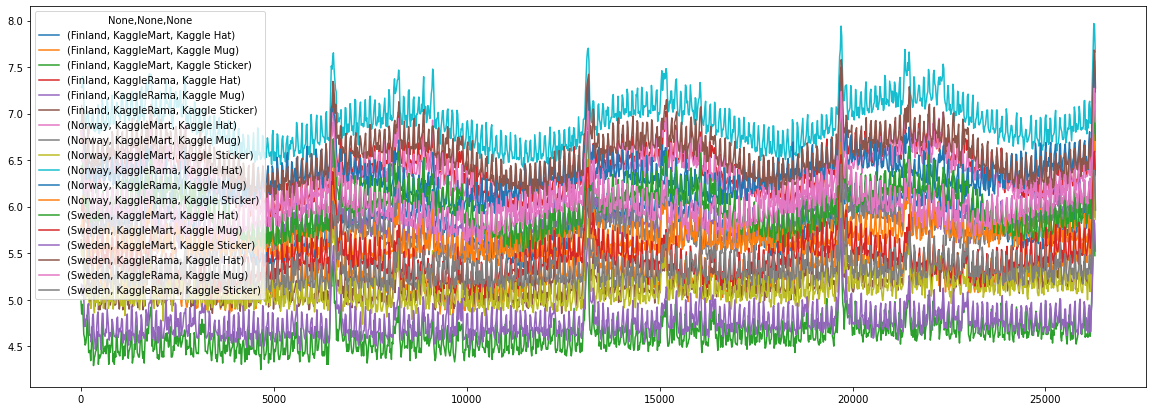

In [34]:
plt.figure(figsize=(20, 7))
df[df.type == 'Train'].groupby(['country','store','product'])['num_sold'].plot(legend = True)
plt.show()

In [35]:
df_drop = df.drop(columns = ['row_id','date','country','store','product'])
train_set = df_drop[df.type == 'Train']
test_set = df_drop[df.type == 'Test']
train_set = train_set.drop(columns = 'type')
test_set = test_set.drop(columns = 'type')
X = train_set.loc[:,train_set.columns!='num_sold']
y = train_set['num_sold']
test_x = test_set.loc[:,test_set.columns!='num_sold']
test_y = test_set['num_sold']

In [36]:
xgb_reg = xgb.XGBRegressor(
    objective ='reg:squarederror',
    subsample = .5,
    min_child_weight = 0.1,
    max_depth = 6,
    learning_rate = 0.05,
    colsample_bytree = 0.5,
    reg_lambda = .01,
    n_estimators = 1000,
    tree_method = 'gpu_hist')

In [38]:
params ={'lambda': 0.001,
         'alpha': 3,
         'eta': 0.01, 
         'colsample_bytree': 0.9, 
         'subsample': 0.6, 
         'learning_rate': 0.005, 
         'n_estimators': 4000, 
         'max_depth': 4, 
         'min_child_weight': 3}
xgb_reg = xgb.XGBRegressor(**params,tree_method = 'gpu_hist')

In [39]:
X_train,X_val,y_train,y_val = train_test_split(X,y, test_size = .25, shuffle=False)

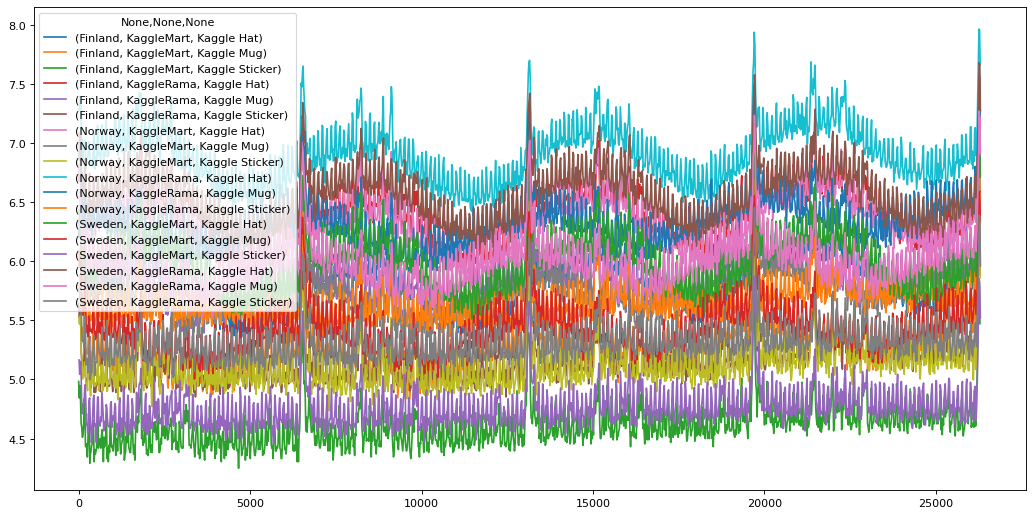

In [50]:
plt.figure(figsize=(16, 8), dpi=80)
df[df.type == 'Train'].groupby(['country','store','product'])['num_sold'].plot(legend = True)
plt.show()